# Worked example: HiRISE views Phobos

Two HiRISE images were once taken showing Phobos are ten minutes apart:
* PSP_007769_9010 taken at: 2008-Mar-23 20:55:31
* PSP_007769_9015 taken at: 2008-Mar-23 21:05:31

<img src="PSP_007769_9010_RED.jpg" width="250">PSP_007769_9010<img src="PSP_007769_9015_RED.jpg" width="250">PSP_007769_9015


First, let's grab the kernels of interest. Go to the NAIF PDS archive and select 'subset' beside the MRO dataset.
https://naif.jpl.nasa.gov/naif/data_archived.html

Let's pull the data for a six hour period that contains the observations. Start and stop times are ```2008-03-23T18:00:00``` and ```2008-03-24T10:00:00``` respectively.
This will generate a small zip file. Unpack this in some working directory. The file contents should include:
```
mro_2008_v14_080323_080324.tm
urls_mrosp_1000_080323_080324.txt
```
These are the meta kernel and the list of the URLs of the actual kernels needed respectively. Now we need to download the the list of kernels using ```wget```. Two files are included that both contain the command needed (they can run on a Windows or Mac/Unix system directly).
```
wget_mrosp_1000_080323_080324.bat
wget_mrosp_1000_080323_080324.tcsh
```
Finally, once downloading is complete, we need to edit the meta kernel. The PATH_VALUES variable is initially set to "./data" and we need to replace this "." with the full path to that 'data' directory. e.g. in my case I replaced "./" with "/Users/shane/Desktop/test/mrosp_1000/".

Let's load up a few common modules as well as spicepy. After that we'll ```furnsh``` the meta kernel and we should be all set to start.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import spiceypy as spice
spice.furnsh('/Users/shane/Desktop/test/mro_2008_v14_080323_080324.tm')


HiRISE is a pushbroom imager (more on this later in the course). So it works by sweeping its FOV across the target through spacecraft motion. In this exercise you should find out how many passes the HiRISE boresight made over Phobos and plot the boresight groundtracks on a map.

First, retrieve the ephemeris times of the observation as well as the names of the HiRISE frame, boresight vector and size of Phobos.

In [73]:
utc1 = "2008-Mar-23 20:55:31"
utc2 = "2008-Mar-23 21:05:31"
et1 = spice.str2et(utc1)
et2 = spice.str2et(utc2)

with spice.no_found_check():
    [spcid, f]  = spice.bodn2c('MRO')                # Retrieve the ID code for the spacecraft
with spice.no_found_check():
    [instid,f] = spice.bodn2c('MRO_HIRISE')          # Retrieve the ID code for the instrument

[shape, frame, bsight, nbounds, bounds] = spice.getfov(instid, 20)     # Find the corner points of the HiRISE FOV
[num, radii] = spice.bodvrd('PHOBOS', 'RADII', 3)                      # Retrieve Phobos Radii to help conversion to lat/lon


Second, determine the time brackets in which Phobos is within the HiRISE FOV. Note being within the field of view doesn't necessarily mean that the instrument boresight intersects the object. Probably best to search within an ~1 hour long window centered on the image times above.

In [74]:
cell = spice.cell_double(2)
spice.wninsd(et1-1800,et2+1800,cell)
ww = spice.cell_double(2000)
spice.gftfov('MRO_HIRISE','PHOBOS', 'ELLIPSOID', 'IAU_PHOBOS', 'LT+S', 'MRO', 1.0, cell, ww)

print("Within an hour of these images, Phobos was with HiRISE's FOV within these time ranges")
for i in range(0,spice.wncard(ww)):
    [wet1, wet2] = spice.wnfetd(ww,i)
    print(spice.et2utc(wet1,'ISOC',1), "  to  ",spice.et2utc(wet2,'ISOC',1))


Within an hour of these images, Phobos was with HiRISE's FOV within these time ranges
2008-03-23T20:55:25.6   to   2008-03-23T20:55:30.9
2008-03-23T20:59:33.2   to   2008-03-23T20:59:36.4
2008-03-23T21:05:25.5   to   2008-03-23T21:05:31.1


Third, loop through these windows and calculate the boresight-surface intersection vector at many (~100) timesteps from each window's begining to end. For valid surface intersections convert these vectors to lon/lat coordinates.

In [59]:
tracks = np.full([spice.wncard(ww),2,100],np.nan)

for i in range(0,spice.wncard(ww)):
    [wet1, wet2] = spice.wnfetd(ww,i)
    tim = np.linspace(wet1,wet2,100)
    
    for j in range(0,100):
        with spice.no_found_check():
            [spoint, trgepc, srfvec,f] = spice.sincpt('ELLIPSOID','PHOBOS',tim[j], 'IAU_PHOBOS', 'LT+S','MRO',frame, bsight)
            [lon, lat, alt] = spice.recpgr('PHOBOS', spoint, radii[0], (radii[0]-radii[2])/radii[0])
        if f == True:
            londeg = 360.0 - lon*180/np.pi
            if londeg > 180:
                londeg -= 360
            tracks[i,0,j] = londeg
            tracks[i,1,j] = lat*180/np.pi


Finally, plot these lon/lat tracks on a map (just a basic plot of latitude vs longitude for now).

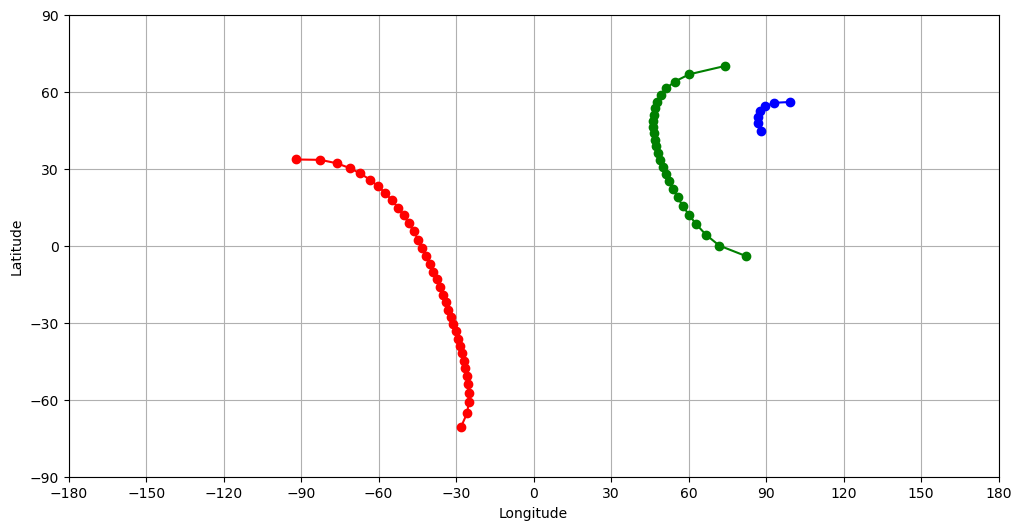

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(tracks[0,0,:], tracks[0,1,:], marker='o', linestyle='-', color='b')
plt.plot(tracks[1,0,:], tracks[1,1,:], marker='o', linestyle='-', color='r')
plt.plot(tracks[2,0,:], tracks[2,1,:], marker='o', linestyle='-', color='g')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.xticks(np.arange(-180, 181, 30))
plt.yticks(np.arange(-90, 91, 30))
plt.show()


Optional extra... Phobos is quite irregular. Repeat the surface intersection calculations using the shape kernel. This file is large so I'll post it on D2L rather than github.

In [75]:
spice.furnsh('/Users/shane/Documents/class/PTYS_551_2022/PTYS_551_kernels/dsk_examples/phobos512.bds')

tracks = np.full([spice.wncard(ww),2,100],np.nan)

for i in range(0,spice.wncard(ww)):
    [wet1, wet2] = spice.wnfetd(ww,i)
    tim = np.linspace(wet1,wet2,100)
    
    for j in range(0,100):
        with spice.no_found_check():
            [spoint, trgepc, srfvec,f] = spice.sincpt('DSK/UNPRIORITIZED','PHOBOS',tim[j], 'IAU_PHOBOS', 'LT+S','MRO',frame, bsight)
            [lon, lat, alt] = spice.recpgr('PHOBOS', spoint, radii[0], (radii[0]-radii[2])/radii[0])
        if f == True:
            londeg = 360.0 - lon*180/np.pi
            if londeg > 180:
                londeg -= 360
            tracks[i,0,j] = londeg
            tracks[i,1,j] = lat*180/np.pi


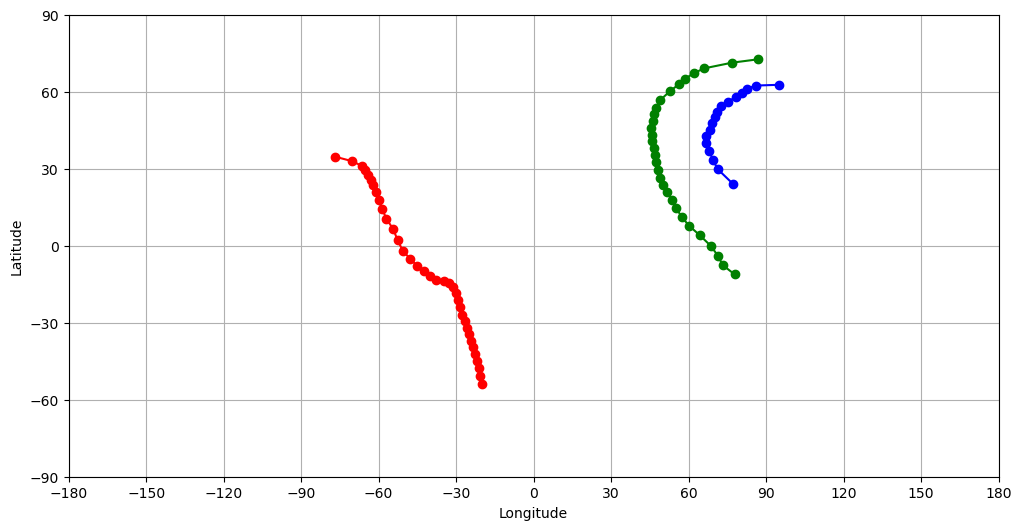

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(tracks[0,0,:], tracks[0,1,:], marker='o', linestyle='-', color='b')
plt.plot(tracks[1,0,:], tracks[1,1,:], marker='o', linestyle='-', color='r')
plt.plot(tracks[2,0,:], tracks[2,1,:], marker='o', linestyle='-', color='g')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.xticks(np.arange(-180, 181, 30))
plt.yticks(np.arange(-90, 91, 30))
plt.show()
